In [63]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import gymnasium as gym
import highway_env
import ale_py

from option_critic import OptionCriticFeatures
from attention_option_critic import AOCFeatures

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
# from highway_env.envs.intersection_env import IntersectionEnv
# intersection_config = IntersectionEnv.default_config()
# intersection_config["observation"]["flatten"] = True

In [67]:
OC_CARTPOLE =  {'num_options': 6, 'temperature': 1.0021572199170095, 'epsilon_start': 0.8892105473942505, 'epsilon_min': 0.16269456380621444, 'epsilon_decay': 130754, 'gamma': 0.9607620430012502, 'tau': 0.8763187663144012, 'termination_reg': 0.00271802276023284, 'entropy_reg': 0.03354402472584794,                                                                                                                       'hidden_size': 64,  'state_size': 96, 'learning_rate': 0.0029659163964686295, 'batch_size': 128, 'critic_freq': 40, 'target_update_freq': 10, 'buffer_size': 2000}
AOC_CARTPOLE = {'num_options': 9, 'temperature': 0.7014647237611604, 'epsilon_start': 0.9266293878140235, 'epsilon_min': 0.1477058909278815,  'epsilon_decay': 696722, 'gamma': 0.8995605059962165, 'tau': 0.9876976682663541, 'termination_reg': 0.02136841630458894, 'entropy_reg': 0.0072884705990544025, 'diversity_reg': 0.03153052105606061, 'sparsity_reg': 0.006558493362079418, 'smoothness_reg': 0.007593783252036938, 'hidden_size': 112, 'state_size': 32, 'learning_rate': 0.001247281645969728,  'batch_size': 224, 'critic_freq': 80, 'target_update_freq': 15, 'buffer_size': 3000}

In [3]:
ENV_IDX = 0
ENV_NAME =    ["CartPole-v1", "LunarLander-v3", "highway-fast-v0", "intersection-v1", "racetrack-v0", "ALE/Pong-v5"][ENV_IDX]
ENV_TYPE =    ["cartpole",    "lunarlander",    "highway",         "intersection",    "racetrack",    "pong"][ENV_IDX]
RENDER_MODE = ["human",       "human",          "rgb_array",       "rgb_array",       "rgb_array",    "human"][ENV_IDX]
TOTAL_TIMESTEPS = int(1e5)

- Feature input, Discrete action space
    - "CartPole-v1"      # (4,) --> 2
    - "LunarLander-v3"     # (8,) --> 4
    - "highway-fast-v0"  # (5, 5) --> 5
    - "intersection-v0"  # (15, 7) --> 3

- Feature input, Continuous action space
    - "intersection-v1"  # (5, 8) --> -1, 1, (2,)
    - "racetrack-v0"     # (2, 12, 12)

- Image input, Discrete action space
    - "ALE/Pong-v5"    # (210, 160, 3)


In [10]:
def get_model(env_name, env_type, model_type, train=False, total_timesteps=TOTAL_TIMESTEPS):
    env = gym.make(env_name)
    if model_type == "aoc":
        model = AOCFeatures(
            env=env,
            num_options=AOC_CARTPOLE["num_options"],
            device="cpu",
            temperature=AOC_CARTPOLE["temperature"],
            epsilon_start=AOC_CARTPOLE["epsilon_start"],
            epsilon_min=AOC_CARTPOLE["epsilon_min"],
            epsilon_decay=AOC_CARTPOLE["epsilon_decay"],
            epsilon_test=0.05,
            gamma=AOC_CARTPOLE["gamma"],
            tau=AOC_CARTPOLE["tau"],
            termination_reg=AOC_CARTPOLE["termination_reg"],
            entropy_reg=AOC_CARTPOLE["entropy_reg"],
            diversity_reg=AOC_CARTPOLE["diversity_reg"],
            sparsity_reg=AOC_CARTPOLE["sparsity_reg"],
            smoothness_reg=AOC_CARTPOLE["smoothness_reg"],
            hidden_size=AOC_CARTPOLE["hidden_size"],
            state_size=AOC_CARTPOLE["state_size"],
            learning_rate=AOC_CARTPOLE["learning_rate"],
            batch_size=AOC_CARTPOLE["batch_size"],
            critic_freq=AOC_CARTPOLE["critic_freq"],
            target_update_freq=AOC_CARTPOLE["target_update_freq"],
            buffer_size=AOC_CARTPOLE["buffer_size"],
            tensorboard_log=f"results/{env_type}_{model_type}/",
            testing=False
        )
        
    elif model_type == "oc":
        model = OptionCriticFeatures(
            env=env,
            num_options=OC_CARTPOLE["num_options"],
            device="cpu",
            temperature=OC_CARTPOLE["temperature"],
            epsilon_start=OC_CARTPOLE["epsilon_start"],
            epsilon_min=OC_CARTPOLE["epsilon_min"],
            epsilon_decay=OC_CARTPOLE["epsilon_decay"],
            epsilon_test=0.05,
            gamma=OC_CARTPOLE["gamma"],
            tau=OC_CARTPOLE["tau"],
            termination_reg=OC_CARTPOLE["termination_reg"],
            entropy_reg=OC_CARTPOLE["entropy_reg"],
            hidden_size=OC_CARTPOLE["hidden_size"],
            state_size=OC_CARTPOLE["state_size"],
            learning_rate=OC_CARTPOLE["learning_rate"],
            batch_size=OC_CARTPOLE["batch_size"],
            critic_freq=OC_CARTPOLE["critic_freq"],
            target_update_freq=OC_CARTPOLE["target_update_freq"],
            buffer_size=OC_CARTPOLE["buffer_size"],
            tensorboard_log=f"results/{env_type}_{model_type}/",
            testing=False
        )

    if train:
        model.learn(total_timesteps=total_timesteps)
        model.save(f"results/{env_type}_{model_type}/model")
    else:
        model.load(f"results/{env_type}_{model_type}/best_model")
        
    return model

In [ ]:
# Note: This crashes if run in .ipynb instead of .py
def simulate_env(model, env_name, render_mode, num_episodes=10):
    env = gym.make(env_name, render_mode=render_mode)
    model.testing = True
    for episode in range(num_episodes):
        done = truncated = False
        obs, info = env.reset()
        option = None
        option_termination = True
        while not (done or truncated):
            option, action, logp, entropy = model.predict(obs, option, option_termination)
            option_termination = model.get_option_termination(obs, option)
            obs, reward, done, truncated, info = env.step(action)
            env.render()
    env.close()

In [64]:
def visualize_primitive_actions_per_option(model, env_name, num_episodes=10):
    env = gym.make(env_name)
    num_actions = env.action_space.n
    num_options = model.num_options
    option_actions = np.zeros((num_actions, num_options))
    model.testing = True
    
    # Collect data for visualizations
    for episode in tqdm(range(num_episodes)):
        done = truncated = False
        obs, info = env.reset()
        option = None
        option_termination = True
        while not (done or truncated):
            option, action, logp, entropy = model.predict(obs, option, option_termination, deterministic=True)
            option_actions[action, option] += 1
            option_termination = model.get_option_termination(obs, option)
            obs, reward, done, truncated, info = env.step(action)
    env.close()
    
    # Normalize across options
    option_sums = option_actions.sum(axis=0)
    norm_option_actions = np.zeros_like(option_actions, dtype=float)
    for col in range(option_actions.shape[1]):
        if option_sums[col] > 0:
            norm_option_actions[:, col] = option_actions[:, col] / option_sums[col]

    plt.figure(figsize=(num_options+1, num_actions))
    plt.imshow(norm_option_actions, cmap="viridis", aspect="auto")
    plt.colorbar(label="Frequency")
    plt.xlabel("Options")
    plt.ylabel("Actions")
    plt.title("Distribution of Primitive Actions Per Option")
    plt.xticks(ticks=np.arange(num_options))
    plt.yticks(ticks=np.arange(num_actions))
    plt.show()
    
    # Normalize across actions
    action_sums = option_actions.sum(axis=1)
    norm_action_options = np.zeros_like(option_actions, dtype=float)
    for row in range(option_actions.shape[0]):
        if action_sums[row] > 0:
            norm_action_options[row, :] = option_actions[row, :] / action_sums[row]

    plt.figure(figsize=(num_options+1, num_actions))
    plt.imshow(norm_action_options, cmap="plasma", aspect="auto")
    plt.colorbar(label="Frequency")
    plt.xlabel("Options")
    plt.ylabel("Actions")
    plt.title("Distribution of Options Per Action (Normalized by Actions)")
    plt.xticks(ticks=np.arange(num_options))
    plt.yticks(ticks=np.arange(num_actions))
    plt.show()
    
    # Histogram for total option usage
    option_totals = option_actions.sum(axis=0)
    total_usage = option_totals.sum()
    option_percent = (option_totals / total_usage) * 100
    
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(num_options), option_percent, color="steelblue")
    plt.xlabel("Options")
    plt.ylabel("Usage Percentage (%)")
    plt.title("Percentage Usage of Each Option")
    plt.xticks(ticks=np.arange(num_options))
    plt.ylim(0, option_percent.max() + 5)
    
    # Display the percentage number above each bar
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, 
                 f"{option_percent[i]:.2f}%", ha='center', va='bottom', fontsize=10)
    
    plt.show()

100%|██████████| 10000/10000 [16:31<00:00, 10.09it/s]


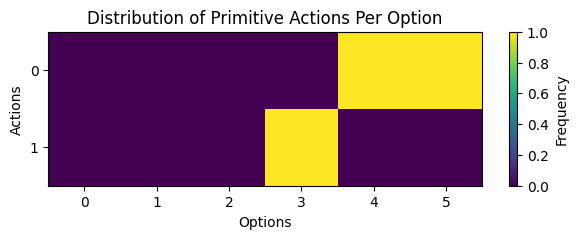

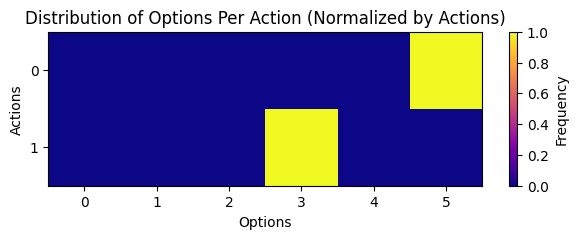

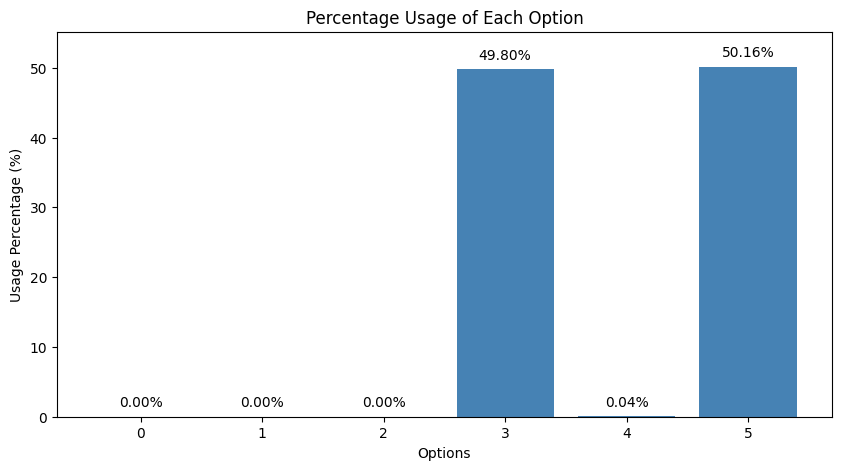

In [ ]:
oc = get_model(env_name=ENV_NAME, env_type=ENV_TYPE, model_type="oc", train=False)

# simulate_env(oc, env_name=ENV_NAME, render_mode=RENDER_MODE, num_episodes=1)
visualize_primitive_actions_per_option(oc, env_name=ENV_NAME, num_episodes=100)

In [98]:
# Visualize AOC attentions per option for each input feature
def get_attention_per_feature(model, env_name, num_episodes=10):
    env = gym.make(env_name)
    num_features = model.in_features
    num_options = model.num_options
    option_attentions = np.zeros((num_options, num_features))
    model.testing = True
    
    # Collect data for visualizations
    for episode in tqdm(range(num_episodes)):
        done = truncated = False
        obs, info = env.reset()
        option = None
        option_termination = True
        while not (done or truncated):
            option, action, logp, entropy = model.predict(obs, option, option_termination, deterministic=True)
            
            _, attention_mask = model.apply_attention(obs, option)
            attention_mask = attention_mask.detach().cpu().numpy().squeeze()
            option_attentions[option, :] += attention_mask
            
            option_termination = model.get_option_termination(obs, option)
            obs, reward, done, truncated, info = env.step(action)
    env.close()
    
    # Normalize across options (feature contributions to each option sum to 1)
    option_sums = option_attentions.sum(axis=1, keepdims=True)
    norm_feature_per_option = np.zeros_like(option_attentions, dtype=float)
    for row in range(option_attentions.shape[0]):
        if option_sums[row] > 0:
            norm_feature_per_option[row, :] = option_attentions[row, :] / option_sums[row]

    plt.figure(figsize=(num_features + 1, num_options))
    plt.imshow(norm_feature_per_option, cmap="viridis", aspect="auto")
    plt.colorbar(label="Attention Weight")
    plt.xlabel("Features")
    plt.ylabel("Options")
    plt.title("Normalized Attention Distribution (Features per Option)")
    plt.xticks(ticks=np.arange(num_features))
    plt.yticks(ticks=np.arange(num_options))
    plt.show()

    # Normalize across features (option contributions to each feature sum to 1)
    feature_sums = option_attentions.sum(axis=0, keepdims=True)
    norm_option_per_feature = np.zeros_like(option_attentions, dtype=float)
    for col in range(option_attentions.shape[1]):
        if feature_sums[0, col] > 0:
            norm_option_per_feature[:, col] = option_attentions[:, col] / feature_sums[0, col]

    plt.figure(figsize=(num_features + 1, num_options))
    plt.imshow(norm_option_per_feature, cmap="plasma", aspect="auto")
    plt.colorbar(label="Attention Weight")
    plt.xlabel("Features")
    plt.ylabel("Options")
    plt.title("Normalized Attention Distribution (Options per Feature)")
    plt.xticks(ticks=np.arange(num_features))
    plt.yticks(ticks=np.arange(num_options))
    plt.show()

100%|██████████| 100/100 [00:01<00:00, 51.19it/s]


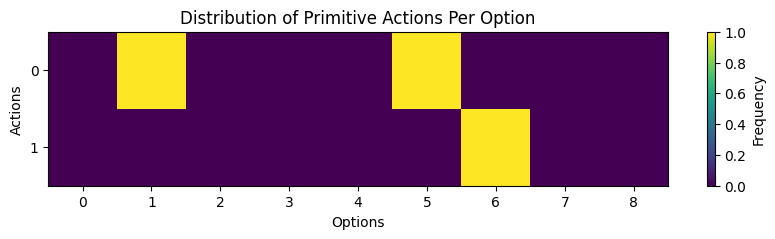

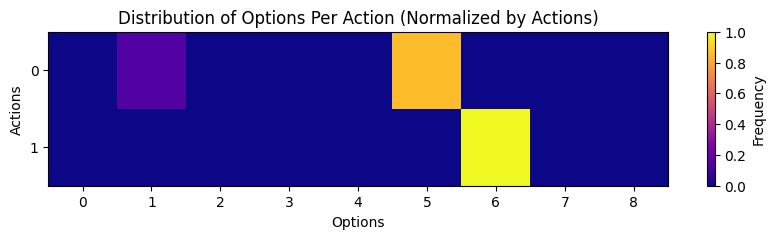

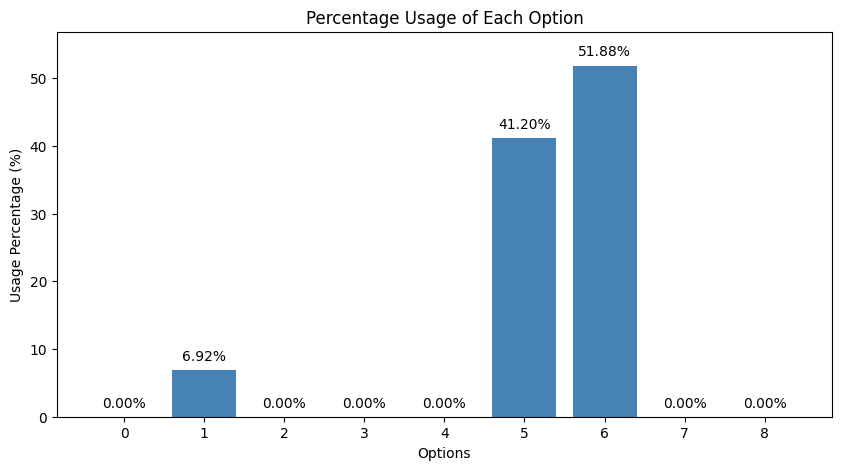

100%|██████████| 100/100 [00:02<00:00, 49.72it/s]


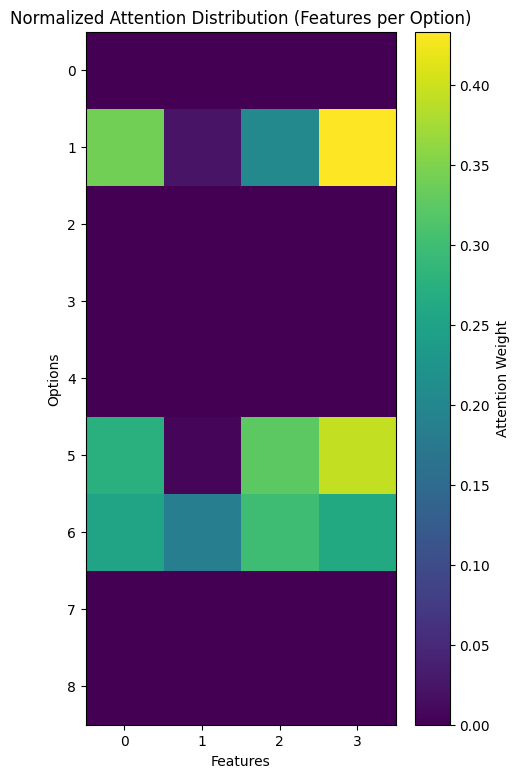

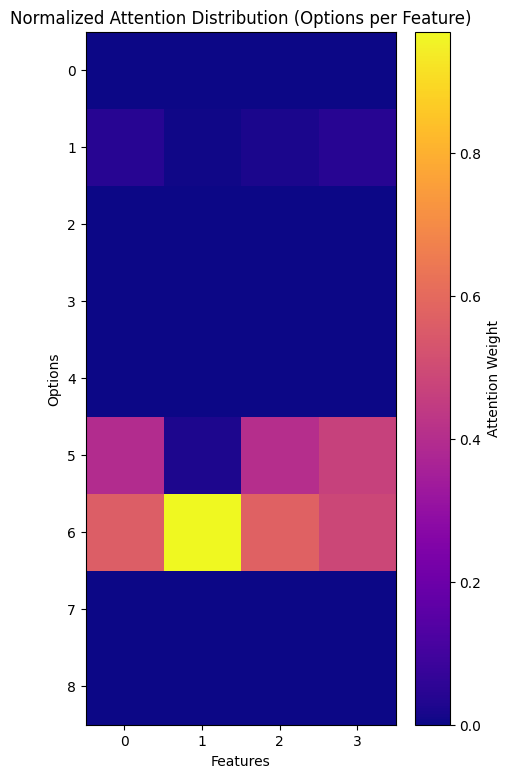

In [101]:
aoc = get_model(env_name=ENV_NAME, env_type=ENV_TYPE, model_type="aoc", train=False)

# simulate_env(model, env_name=ENV_NAME, render_mode=RENDER_MODE, num_episodes=1)
visualize_primitive_actions_per_option(aoc, env_name=ENV_NAME, num_episodes=100)
get_attention_per_feature(aoc, env_name=ENV_NAME, num_episodes=100)